In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn.model_selection import StratifiedKFold

import seaborn as sns
from imblearn.over_sampling import SMOTE

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier  # Example model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [241]:
pd.set_option('display.max_columns', None)  # Show all columns
# print(df.head())  # Display the first few rows to check the data

#Cleans a file of NaN values
def csv_cleaner(path, coi):
    df = pd.read_csv(path) 

    df = df[coi]
    print(len(df))

    # Count NaNs in each column
    nan_count = df.isnull().sum()

    # Display columns with NaNs
    print(nan_count[nan_count > 0])
    print(np.max(nan_count) / len(df))

    # drop the exceptional columns that still have NaNs
    NaNx_clean = df.dropna()
    print(len(NaNx_clean))

    return NaNx_clean

#Depending on the data being used for the holdout set, set paths and names of all columns
def data_chooser(JorD, PorS):
    path_RData = 'gaia_matched/RANDOM_Stars_Crossmatch.csv'
    if JorD == 0: #Johnston is the holdout set
        path_HO_MDwarfs = 'gaia_matched/DESY_MDwarfs_Crossmatch.csv'
        path_HO_NotMDwarfs = 'gaia_matched/DESY_NotMDwarfs_Crossmatch.csv'
        path_MDwarfs = 'gaia_matched/JOHNSTON_MDwarfs_Crossmatch.csv'
        path_NotMDwarfs = 'gaia_matched/JOHNSTON_NotMDwarfs_Crossmatch.csv'
    elif JorD == 1: #DESY is the holdout set
        path_MDwarfs = 'gaia_matched/DESY_MDwarfs_Crossmatch.csv'
        path_NotMDwarfs = 'gaia_matched/DESY_NotMDwarfs_Crossmatch.csv'
        path_HO_MDwarfs = 'gaia_matched/JOHNSTON_MDwarfs_Crossmatch.csv'
        path_HO_NotMDwarfs = 'gaia_matched/JOHNSTON_NotMDwarfs_Crossmatch.csv'
    if PorS == 0:
        coi =  ['ra_epoch2000','dec_epoch2000','errHalfMaj','errHalfMin','errPosAng',
                'astrometric_n_good_obs_al','astrometric_gof_al',
                'astrometric_chi2_al','astrometric_excess_noise','astrometric_excess_noise_sig',
                'astrometric_params_solved','visibility_periods_used','dr2_rv_nb_transits',
                'phot_g_mean_mag_error','phot_bp_mean_mag_error','phot_rp_mean_mag_error',
                'phot_g_mean_mag_corrected','phot_g_mean_mag_error_corrected','phot_g_mean_flux_corrected',
                'phot_bp_rp_excess_factor_corrected','ra_epoch2000_error','dec_epoch2000_error',
                'ra_dec_epoch2000_corr','angDist']
    elif PorS == 1:
        coi =  ['phot_g_mean_flux', 'phot_bp_mean_flux','phot_rp_mean_flux', 'phot_bp_rp_excess_factor', 
                'bp_rp','phot_g_mean_flux_error', 'phot_bp_mean_flux_error', 'phot_g_mean_mag',
                'phot_bp_mean_mag', 'phot_rp_mean_mag','phot_g_mean_mag_error', 'phot_bp_mean_mag_error',
                'phot_rp_mean_mag_error','phot_g_mean_mag_corrected', 'phot_g_mean_mag_error_corrected',
                'phot_g_mean_flux_corrected', 'phot_bp_rp_excess_factor_corrected']
    elif PorS == 2:
        coi =  ['phot_g_mean_flux', 'phot_bp_mean_flux','phot_rp_mean_flux', 'phot_bp_rp_excess_factor', 
                'bp_rp','phot_g_mean_flux_error', 'phot_bp_mean_flux_error', 'phot_g_mean_mag',
                'phot_bp_mean_mag', 'phot_rp_mean_mag','phot_g_mean_mag_error', 'phot_bp_mean_mag_error',
                'phot_rp_mean_mag_error','phot_g_mean_mag_corrected', 'phot_g_mean_mag_error_corrected',
                'phot_g_mean_flux_corrected', 'phot_bp_rp_excess_factor_corrected',
                
                'ra_epoch2000','dec_epoch2000','errHalfMaj','errHalfMin','errPosAng',
                'astrometric_n_good_obs_al','astrometric_gof_al',
                'astrometric_chi2_al','astrometric_excess_noise','astrometric_excess_noise_sig',
                'astrometric_params_solved','visibility_periods_used','dr2_rv_nb_transits',
                'phot_g_mean_mag_error','phot_bp_mean_mag_error','phot_rp_mean_mag_error',
                'phot_g_mean_mag_corrected','phot_g_mean_mag_error_corrected','phot_g_mean_flux_corrected',
                'phot_bp_rp_excess_factor_corrected','ra_epoch2000_error','dec_epoch2000_error',
                'ra_dec_epoch2000_corr','angDist']

    MDwarfs = csv_cleaner(path_MDwarfs, coi)
    MDwarfs['SPEC'] = 'M'

    HO_MDwarfs = csv_cleaner(path_HO_MDwarfs,coi)
    HO_MDwarfs['SPEC'] = 'M'

    NotMDwarfs = csv_cleaner(path_NotMDwarfs, coi)
    NotMDwarfs['SPEC'] = 'B'

    HO_NotMDwarfs = csv_cleaner(path_HO_NotMDwarfs, coi)
    HO_NotMDwarfs['SPEC'] = 'B'

    RData = csv_cleaner(path_RData, coi)
    RData['SPEC'] = 'ND'

    length = len(RData)

    all_dat = pd.concat([MDwarfs, NotMDwarfs, RData[:int(length/2)]], axis=0)
    all_HO_dat = pd.concat([HO_MDwarfs, HO_NotMDwarfs, RData[int(length/2):]], axis=0)
    return all_dat, all_HO_dat

#Only gaia data which are not strings nor predominantly NaNs

all_dat, all_HO_dat = data_chooser(0, 2) 
# first number of 0 (Johnston Holdout) is always better. 
# Second number can be [0: Parameter space, 1: Spectroscopy, 2: Both]

print()

597
phot_g_mean_flux                       1
phot_bp_mean_flux                     24
phot_rp_mean_flux                     20
phot_bp_rp_excess_factor              24
bp_rp                                 24
phot_g_mean_flux_error                 1
phot_bp_mean_flux_error               24
phot_g_mean_mag                        1
phot_bp_mean_mag                      24
phot_rp_mean_mag                      20
phot_g_mean_mag_error                  1
phot_bp_mean_mag_error                24
phot_rp_mean_mag_error                20
phot_g_mean_mag_corrected              1
phot_g_mean_mag_error_corrected        1
phot_g_mean_flux_corrected             1
phot_bp_rp_excess_factor_corrected    24
phot_g_mean_mag_error                  1
phot_bp_mean_mag_error                24
phot_rp_mean_mag_error                20
phot_g_mean_mag_corrected              1
phot_g_mean_mag_error_corrected        1
phot_g_mean_flux_corrected             1
phot_bp_rp_excess_factor_corrected    24
dtype: int64

In [243]:
missclasses = []

for i in range(0, all_dat.columns.size-1):   
    all_dat, all_HO_dat = data_chooser(0, 2) 
    
    X = all_dat.drop(columns=['SPEC'])  # Features
    X.pop(X.columns[i]) #dropping something at an index
    y = all_dat['SPEC']  # Labels

    print(y.value_counts())

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # KNN classifier
    knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    y_true_all = []
    y_pred_all = []

    # Cross-validation loop
    for train_index, val_index in skf.split(X_scaled, y):
        # Split data into training and validation sets
        X_train, X_val = X_scaled[train_index], X_scaled[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Apply SMOTE to the training data
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

        # Train the model
        knn.fit(X_resampled, y_resampled)

        # Predict on the validation set
        y_pred = knn.predict(X_val)

        # Collect true labels and predictions
        y_true_all.extend(y_val)
        y_pred_all.extend(y_pred)

    # Predictions
    #print(pd.Series(y_pred_all).value_counts())

    #print(f"Accuracy: {accuracy_score(y_true_all, y_pred_all)}")
    #print("Classification Report (Cross-Validation):")
    #print(classification_report(y_true_all, y_pred_all, target_names=['B', 'M', 'ND']))

    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    misclass = 1 - (scores.mean())
    missclasses.append(misclass)

print(missclasses)

#Prints the missclassifications when taking away one column of data at a time
#notice that the rates are highest for ang_dist
#and only a little higher than average for bv_rp
#around 0.025 for all data included
#this is a bit odd, I don't fully understand it
#it was someone's idea for a similar problem on stackoverflow

597
phot_g_mean_flux                       1
phot_bp_mean_flux                     24
phot_rp_mean_flux                     20
phot_bp_rp_excess_factor              24
bp_rp                                 24
phot_g_mean_flux_error                 1
phot_bp_mean_flux_error               24
phot_g_mean_mag                        1
phot_bp_mean_mag                      24
phot_rp_mean_mag                      20
phot_g_mean_mag_error                  1
phot_bp_mean_mag_error                24
phot_rp_mean_mag_error                20
phot_g_mean_mag_corrected              1
phot_g_mean_mag_error_corrected        1
phot_g_mean_flux_corrected             1
phot_bp_rp_excess_factor_corrected    24
phot_g_mean_mag_error                  1
phot_bp_mean_mag_error                24
phot_rp_mean_mag_error                20
phot_g_mean_mag_corrected              1
phot_g_mean_mag_error_corrected        1
phot_g_mean_flux_corrected             1
phot_bp_rp_excess_factor_corrected    24
dtype: int64

70902
phot_g_mean_flux                       168
phot_bp_mean_flux                     5569
phot_rp_mean_flux                     5149
phot_bp_rp_excess_factor              5611
bp_rp                                 5611
phot_g_mean_flux_error                 168
phot_bp_mean_flux_error               5569
phot_g_mean_mag                        168
phot_bp_mean_mag                      5569
phot_rp_mean_mag                      5149
phot_g_mean_mag_error                  168
phot_bp_mean_mag_error                5569
phot_rp_mean_mag_error                5149
phot_g_mean_mag_corrected              168
phot_g_mean_mag_error_corrected        168
phot_g_mean_flux_corrected             168
phot_bp_rp_excess_factor_corrected    5611
phot_g_mean_mag_error                  168
phot_bp_mean_mag_error                5569
phot_rp_mean_mag_error                5149
phot_g_mean_mag_corrected              168
phot_g_mean_mag_error_corrected        168
phot_g_mean_flux_corrected             168
phot_

70902
phot_g_mean_flux                       168
phot_bp_mean_flux                     5569
phot_rp_mean_flux                     5149
phot_bp_rp_excess_factor              5611
bp_rp                                 5611
phot_g_mean_flux_error                 168
phot_bp_mean_flux_error               5569
phot_g_mean_mag                        168
phot_bp_mean_mag                      5569
phot_rp_mean_mag                      5149
phot_g_mean_mag_error                  168
phot_bp_mean_mag_error                5569
phot_rp_mean_mag_error                5149
phot_g_mean_mag_corrected              168
phot_g_mean_mag_error_corrected        168
phot_g_mean_flux_corrected             168
phot_bp_rp_excess_factor_corrected    5611
phot_g_mean_mag_error                  168
phot_bp_mean_mag_error                5569
phot_rp_mean_mag_error                5149
phot_g_mean_mag_corrected              168
phot_g_mean_mag_error_corrected        168
phot_g_mean_flux_corrected             168
phot_

70902
phot_g_mean_flux                       168
phot_bp_mean_flux                     5569
phot_rp_mean_flux                     5149
phot_bp_rp_excess_factor              5611
bp_rp                                 5611
phot_g_mean_flux_error                 168
phot_bp_mean_flux_error               5569
phot_g_mean_mag                        168
phot_bp_mean_mag                      5569
phot_rp_mean_mag                      5149
phot_g_mean_mag_error                  168
phot_bp_mean_mag_error                5569
phot_rp_mean_mag_error                5149
phot_g_mean_mag_corrected              168
phot_g_mean_mag_error_corrected        168
phot_g_mean_flux_corrected             168
phot_bp_rp_excess_factor_corrected    5611
phot_g_mean_mag_error                  168
phot_bp_mean_mag_error                5569
phot_rp_mean_mag_error                5149
phot_g_mean_mag_corrected              168
phot_g_mean_mag_error_corrected        168
phot_g_mean_flux_corrected             168
phot_

70902
phot_g_mean_flux                       168
phot_bp_mean_flux                     5569
phot_rp_mean_flux                     5149
phot_bp_rp_excess_factor              5611
bp_rp                                 5611
phot_g_mean_flux_error                 168
phot_bp_mean_flux_error               5569
phot_g_mean_mag                        168
phot_bp_mean_mag                      5569
phot_rp_mean_mag                      5149
phot_g_mean_mag_error                  168
phot_bp_mean_mag_error                5569
phot_rp_mean_mag_error                5149
phot_g_mean_mag_corrected              168
phot_g_mean_mag_error_corrected        168
phot_g_mean_flux_corrected             168
phot_bp_rp_excess_factor_corrected    5611
phot_g_mean_mag_error                  168
phot_bp_mean_mag_error                5569
phot_rp_mean_mag_error                5149
phot_g_mean_mag_corrected              168
phot_g_mean_mag_error_corrected        168
phot_g_mean_flux_corrected             168
phot_

70902
phot_g_mean_flux                       168
phot_bp_mean_flux                     5569
phot_rp_mean_flux                     5149
phot_bp_rp_excess_factor              5611
bp_rp                                 5611
phot_g_mean_flux_error                 168
phot_bp_mean_flux_error               5569
phot_g_mean_mag                        168
phot_bp_mean_mag                      5569
phot_rp_mean_mag                      5149
phot_g_mean_mag_error                  168
phot_bp_mean_mag_error                5569
phot_rp_mean_mag_error                5149
phot_g_mean_mag_corrected              168
phot_g_mean_mag_error_corrected        168
phot_g_mean_flux_corrected             168
phot_bp_rp_excess_factor_corrected    5611
phot_g_mean_mag_error                  168
phot_bp_mean_mag_error                5569
phot_rp_mean_mag_error                5149
phot_g_mean_mag_corrected              168
phot_g_mean_mag_error_corrected        168
phot_g_mean_flux_corrected             168
phot_

70902
phot_g_mean_flux                       168
phot_bp_mean_flux                     5569
phot_rp_mean_flux                     5149
phot_bp_rp_excess_factor              5611
bp_rp                                 5611
phot_g_mean_flux_error                 168
phot_bp_mean_flux_error               5569
phot_g_mean_mag                        168
phot_bp_mean_mag                      5569
phot_rp_mean_mag                      5149
phot_g_mean_mag_error                  168
phot_bp_mean_mag_error                5569
phot_rp_mean_mag_error                5149
phot_g_mean_mag_corrected              168
phot_g_mean_mag_error_corrected        168
phot_g_mean_flux_corrected             168
phot_bp_rp_excess_factor_corrected    5611
phot_g_mean_mag_error                  168
phot_bp_mean_mag_error                5569
phot_rp_mean_mag_error                5149
phot_g_mean_mag_corrected              168
phot_g_mean_mag_error_corrected        168
phot_g_mean_flux_corrected             168
phot_

70902
phot_g_mean_flux                       168
phot_bp_mean_flux                     5569
phot_rp_mean_flux                     5149
phot_bp_rp_excess_factor              5611
bp_rp                                 5611
phot_g_mean_flux_error                 168
phot_bp_mean_flux_error               5569
phot_g_mean_mag                        168
phot_bp_mean_mag                      5569
phot_rp_mean_mag                      5149
phot_g_mean_mag_error                  168
phot_bp_mean_mag_error                5569
phot_rp_mean_mag_error                5149
phot_g_mean_mag_corrected              168
phot_g_mean_mag_error_corrected        168
phot_g_mean_flux_corrected             168
phot_bp_rp_excess_factor_corrected    5611
phot_g_mean_mag_error                  168
phot_bp_mean_mag_error                5569
phot_rp_mean_mag_error                5149
phot_g_mean_mag_corrected              168
phot_g_mean_mag_error_corrected        168
phot_g_mean_flux_corrected             168
phot_

70902
phot_g_mean_flux                       168
phot_bp_mean_flux                     5569
phot_rp_mean_flux                     5149
phot_bp_rp_excess_factor              5611
bp_rp                                 5611
phot_g_mean_flux_error                 168
phot_bp_mean_flux_error               5569
phot_g_mean_mag                        168
phot_bp_mean_mag                      5569
phot_rp_mean_mag                      5149
phot_g_mean_mag_error                  168
phot_bp_mean_mag_error                5569
phot_rp_mean_mag_error                5149
phot_g_mean_mag_corrected              168
phot_g_mean_mag_error_corrected        168
phot_g_mean_flux_corrected             168
phot_bp_rp_excess_factor_corrected    5611
phot_g_mean_mag_error                  168
phot_bp_mean_mag_error                5569
phot_rp_mean_mag_error                5149
phot_g_mean_mag_corrected              168
phot_g_mean_mag_error_corrected        168
phot_g_mean_flux_corrected             168
phot_

70902
phot_g_mean_flux                       168
phot_bp_mean_flux                     5569
phot_rp_mean_flux                     5149
phot_bp_rp_excess_factor              5611
bp_rp                                 5611
phot_g_mean_flux_error                 168
phot_bp_mean_flux_error               5569
phot_g_mean_mag                        168
phot_bp_mean_mag                      5569
phot_rp_mean_mag                      5149
phot_g_mean_mag_error                  168
phot_bp_mean_mag_error                5569
phot_rp_mean_mag_error                5149
phot_g_mean_mag_corrected              168
phot_g_mean_mag_error_corrected        168
phot_g_mean_flux_corrected             168
phot_bp_rp_excess_factor_corrected    5611
phot_g_mean_mag_error                  168
phot_bp_mean_mag_error                5569
phot_rp_mean_mag_error                5149
phot_g_mean_mag_corrected              168
phot_g_mean_mag_error_corrected        168
phot_g_mean_flux_corrected             168
phot_

70902
phot_g_mean_flux                       168
phot_bp_mean_flux                     5569
phot_rp_mean_flux                     5149
phot_bp_rp_excess_factor              5611
bp_rp                                 5611
phot_g_mean_flux_error                 168
phot_bp_mean_flux_error               5569
phot_g_mean_mag                        168
phot_bp_mean_mag                      5569
phot_rp_mean_mag                      5149
phot_g_mean_mag_error                  168
phot_bp_mean_mag_error                5569
phot_rp_mean_mag_error                5149
phot_g_mean_mag_corrected              168
phot_g_mean_mag_error_corrected        168
phot_g_mean_flux_corrected             168
phot_bp_rp_excess_factor_corrected    5611
phot_g_mean_mag_error                  168
phot_bp_mean_mag_error                5569
phot_rp_mean_mag_error                5149
phot_g_mean_mag_corrected              168
phot_g_mean_mag_error_corrected        168
phot_g_mean_flux_corrected             168
phot_

70902
phot_g_mean_flux                       168
phot_bp_mean_flux                     5569
phot_rp_mean_flux                     5149
phot_bp_rp_excess_factor              5611
bp_rp                                 5611
phot_g_mean_flux_error                 168
phot_bp_mean_flux_error               5569
phot_g_mean_mag                        168
phot_bp_mean_mag                      5569
phot_rp_mean_mag                      5149
phot_g_mean_mag_error                  168
phot_bp_mean_mag_error                5569
phot_rp_mean_mag_error                5149
phot_g_mean_mag_corrected              168
phot_g_mean_mag_error_corrected        168
phot_g_mean_flux_corrected             168
phot_bp_rp_excess_factor_corrected    5611
phot_g_mean_mag_error                  168
phot_bp_mean_mag_error                5569
phot_rp_mean_mag_error                5149
phot_g_mean_mag_corrected              168
phot_g_mean_mag_error_corrected        168
phot_g_mean_flux_corrected             168
phot_

70902
phot_g_mean_flux                       168
phot_bp_mean_flux                     5569
phot_rp_mean_flux                     5149
phot_bp_rp_excess_factor              5611
bp_rp                                 5611
phot_g_mean_flux_error                 168
phot_bp_mean_flux_error               5569
phot_g_mean_mag                        168
phot_bp_mean_mag                      5569
phot_rp_mean_mag                      5149
phot_g_mean_mag_error                  168
phot_bp_mean_mag_error                5569
phot_rp_mean_mag_error                5149
phot_g_mean_mag_corrected              168
phot_g_mean_mag_error_corrected        168
phot_g_mean_flux_corrected             168
phot_bp_rp_excess_factor_corrected    5611
phot_g_mean_mag_error                  168
phot_bp_mean_mag_error                5569
phot_rp_mean_mag_error                5149
phot_g_mean_mag_corrected              168
phot_g_mean_mag_error_corrected        168
phot_g_mean_flux_corrected             168
phot_

70902
phot_g_mean_flux                       168
phot_bp_mean_flux                     5569
phot_rp_mean_flux                     5149
phot_bp_rp_excess_factor              5611
bp_rp                                 5611
phot_g_mean_flux_error                 168
phot_bp_mean_flux_error               5569
phot_g_mean_mag                        168
phot_bp_mean_mag                      5569
phot_rp_mean_mag                      5149
phot_g_mean_mag_error                  168
phot_bp_mean_mag_error                5569
phot_rp_mean_mag_error                5149
phot_g_mean_mag_corrected              168
phot_g_mean_mag_error_corrected        168
phot_g_mean_flux_corrected             168
phot_bp_rp_excess_factor_corrected    5611
phot_g_mean_mag_error                  168
phot_bp_mean_mag_error                5569
phot_rp_mean_mag_error                5149
phot_g_mean_mag_corrected              168
phot_g_mean_mag_error_corrected        168
phot_g_mean_flux_corrected             168
phot_

70902
phot_g_mean_flux                       168
phot_bp_mean_flux                     5569
phot_rp_mean_flux                     5149
phot_bp_rp_excess_factor              5611
bp_rp                                 5611
phot_g_mean_flux_error                 168
phot_bp_mean_flux_error               5569
phot_g_mean_mag                        168
phot_bp_mean_mag                      5569
phot_rp_mean_mag                      5149
phot_g_mean_mag_error                  168
phot_bp_mean_mag_error                5569
phot_rp_mean_mag_error                5149
phot_g_mean_mag_corrected              168
phot_g_mean_mag_error_corrected        168
phot_g_mean_flux_corrected             168
phot_bp_rp_excess_factor_corrected    5611
phot_g_mean_mag_error                  168
phot_bp_mean_mag_error                5569
phot_rp_mean_mag_error                5149
phot_g_mean_mag_corrected              168
phot_g_mean_mag_error_corrected        168
phot_g_mean_flux_corrected             168
phot_

70902
phot_g_mean_flux                       168
phot_bp_mean_flux                     5569
phot_rp_mean_flux                     5149
phot_bp_rp_excess_factor              5611
bp_rp                                 5611
phot_g_mean_flux_error                 168
phot_bp_mean_flux_error               5569
phot_g_mean_mag                        168
phot_bp_mean_mag                      5569
phot_rp_mean_mag                      5149
phot_g_mean_mag_error                  168
phot_bp_mean_mag_error                5569
phot_rp_mean_mag_error                5149
phot_g_mean_mag_corrected              168
phot_g_mean_mag_error_corrected        168
phot_g_mean_flux_corrected             168
phot_bp_rp_excess_factor_corrected    5611
phot_g_mean_mag_error                  168
phot_bp_mean_mag_error                5569
phot_rp_mean_mag_error                5149
phot_g_mean_mag_corrected              168
phot_g_mean_mag_error_corrected        168
phot_g_mean_flux_corrected             168
phot_

70902
phot_g_mean_flux                       168
phot_bp_mean_flux                     5569
phot_rp_mean_flux                     5149
phot_bp_rp_excess_factor              5611
bp_rp                                 5611
phot_g_mean_flux_error                 168
phot_bp_mean_flux_error               5569
phot_g_mean_mag                        168
phot_bp_mean_mag                      5569
phot_rp_mean_mag                      5149
phot_g_mean_mag_error                  168
phot_bp_mean_mag_error                5569
phot_rp_mean_mag_error                5149
phot_g_mean_mag_corrected              168
phot_g_mean_mag_error_corrected        168
phot_g_mean_flux_corrected             168
phot_bp_rp_excess_factor_corrected    5611
phot_g_mean_mag_error                  168
phot_bp_mean_mag_error                5569
phot_rp_mean_mag_error                5149
phot_g_mean_mag_corrected              168
phot_g_mean_mag_error_corrected        168
phot_g_mean_flux_corrected             168
phot_

70902
phot_g_mean_flux                       168
phot_bp_mean_flux                     5569
phot_rp_mean_flux                     5149
phot_bp_rp_excess_factor              5611
bp_rp                                 5611
phot_g_mean_flux_error                 168
phot_bp_mean_flux_error               5569
phot_g_mean_mag                        168
phot_bp_mean_mag                      5569
phot_rp_mean_mag                      5149
phot_g_mean_mag_error                  168
phot_bp_mean_mag_error                5569
phot_rp_mean_mag_error                5149
phot_g_mean_mag_corrected              168
phot_g_mean_mag_error_corrected        168
phot_g_mean_flux_corrected             168
phot_bp_rp_excess_factor_corrected    5611
phot_g_mean_mag_error                  168
phot_bp_mean_mag_error                5569
phot_rp_mean_mag_error                5149
phot_g_mean_mag_corrected              168
phot_g_mean_mag_error_corrected        168
phot_g_mean_flux_corrected             168
phot_

70902
phot_g_mean_flux                       168
phot_bp_mean_flux                     5569
phot_rp_mean_flux                     5149
phot_bp_rp_excess_factor              5611
bp_rp                                 5611
phot_g_mean_flux_error                 168
phot_bp_mean_flux_error               5569
phot_g_mean_mag                        168
phot_bp_mean_mag                      5569
phot_rp_mean_mag                      5149
phot_g_mean_mag_error                  168
phot_bp_mean_mag_error                5569
phot_rp_mean_mag_error                5149
phot_g_mean_mag_corrected              168
phot_g_mean_mag_error_corrected        168
phot_g_mean_flux_corrected             168
phot_bp_rp_excess_factor_corrected    5611
phot_g_mean_mag_error                  168
phot_bp_mean_mag_error                5569
phot_rp_mean_mag_error                5149
phot_g_mean_mag_corrected              168
phot_g_mean_mag_error_corrected        168
phot_g_mean_flux_corrected             168
phot_

70902
phot_g_mean_flux                       168
phot_bp_mean_flux                     5569
phot_rp_mean_flux                     5149
phot_bp_rp_excess_factor              5611
bp_rp                                 5611
phot_g_mean_flux_error                 168
phot_bp_mean_flux_error               5569
phot_g_mean_mag                        168
phot_bp_mean_mag                      5569
phot_rp_mean_mag                      5149
phot_g_mean_mag_error                  168
phot_bp_mean_mag_error                5569
phot_rp_mean_mag_error                5149
phot_g_mean_mag_corrected              168
phot_g_mean_mag_error_corrected        168
phot_g_mean_flux_corrected             168
phot_bp_rp_excess_factor_corrected    5611
phot_g_mean_mag_error                  168
phot_bp_mean_mag_error                5569
phot_rp_mean_mag_error                5149
phot_g_mean_mag_corrected              168
phot_g_mean_mag_error_corrected        168
phot_g_mean_flux_corrected             168
phot_

70902
phot_g_mean_flux                       168
phot_bp_mean_flux                     5569
phot_rp_mean_flux                     5149
phot_bp_rp_excess_factor              5611
bp_rp                                 5611
phot_g_mean_flux_error                 168
phot_bp_mean_flux_error               5569
phot_g_mean_mag                        168
phot_bp_mean_mag                      5569
phot_rp_mean_mag                      5149
phot_g_mean_mag_error                  168
phot_bp_mean_mag_error                5569
phot_rp_mean_mag_error                5149
phot_g_mean_mag_corrected              168
phot_g_mean_mag_error_corrected        168
phot_g_mean_flux_corrected             168
phot_bp_rp_excess_factor_corrected    5611
phot_g_mean_mag_error                  168
phot_bp_mean_mag_error                5569
phot_rp_mean_mag_error                5149
phot_g_mean_mag_corrected              168
phot_g_mean_mag_error_corrected        168
phot_g_mean_flux_corrected             168
phot_

In [256]:
all_dat, all_HO_dat = data_chooser(0, 2) 
X = all_dat[['bp_rp', 'angDist', 'SPEC']] #'bp_rp', 'angDist', 'phot_rp_mean_mag'
X = X.drop(columns=['SPEC'])
y = all_dat['SPEC']

print(y.value_counts())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# KNN classifier
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

y_true_all = []
y_pred_all = []

# Cross-validation loop
for train_index, val_index in skf.split(X_scaled, y):
    # Split data into training and validation sets
    X_train, X_val = X_scaled[train_index], X_scaled[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Apply SMOTE to the training data
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    # Train the model
    knn.fit(X_resampled, y_resampled)

    # Predict on the validation set
    y_pred = knn.predict(X_val)

    # Collect true labels and predictions
    y_true_all.extend(y_val)
    y_pred_all.extend(y_pred)

# Predictions
print(pd.Series(y_pred_all).value_counts())

print(f"Accuracy: {accuracy_score(y_true_all, y_pred_all)}")
print("Classification Report (Cross-Validation):")
print(classification_report(y_true_all, y_pred_all, target_names=['B', 'M', 'ND']))

#FOR JUST ang_Dist

#precision    recall  f1-score   support

#           B       0.08      0.41      0.13      1045
#           M       0.08      0.45      0.14       573
#          ND       0.99      0.78      0.87     32645

#    accuracy                           0.76     34263
#   macro avg       0.38      0.54      0.38     34263
#weighted avg       0.95      0.76      0.84     34263

#FOR JUST bp_rp

#Classification Report (Cross-Validation):
#              precision    recall  f1-score   support

#           B       0.09      0.48      0.16      1045
#           M       0.13      0.50      0.21       573
#          ND       0.99      0.81      0.89     32645

#    accuracy                           0.80     34263
#   macro avg       0.41      0.60      0.42     34263
#weighted avg       0.95      0.80      0.86     34263

#FOR BOTH

#Classification Report (Cross-Validation):
#              precision    recall  f1-score   support

#           B       0.14      0.47      0.22      1045
#           M       0.17      0.51      0.25       573
#          ND       0.99      0.88      0.93     32645

#    accuracy                           0.86     34263
#   macro avg       0.43      0.62      0.47     34263
#weighted avg       0.95      0.86      0.90     34263

#FOR JUST phot_rp_mean_mag

#Classification Report (Cross-Validation):
#              precision    recall  f1-score   support

#           B       0.04      0.44      0.08      1045
#           M       0.03      0.41      0.06       573
#          ND       0.97      0.47      0.63     32645

#    accuracy                           0.47     34263
#   macro avg       0.35      0.44      0.25     34263
#weighted avg       0.92      0.47      0.60     34263

#Classification is most accurate with all data, then with both bv_rp & ang_dist, then only bp_rp,
#then only ang_dist, and any others (phot_rp_mean_mag) as an example are much lower
#That's what we expect! Yay!

597
phot_g_mean_flux                       1
phot_bp_mean_flux                     24
phot_rp_mean_flux                     20
phot_bp_rp_excess_factor              24
bp_rp                                 24
phot_g_mean_flux_error                 1
phot_bp_mean_flux_error               24
phot_g_mean_mag                        1
phot_bp_mean_mag                      24
phot_rp_mean_mag                      20
phot_g_mean_mag_error                  1
phot_bp_mean_mag_error                24
phot_rp_mean_mag_error                20
phot_g_mean_mag_corrected              1
phot_g_mean_mag_error_corrected        1
phot_g_mean_flux_corrected             1
phot_bp_rp_excess_factor_corrected    24
phot_g_mean_mag_error                  1
phot_bp_mean_mag_error                24
phot_rp_mean_mag_error                20
phot_g_mean_mag_corrected              1
phot_g_mean_mag_error_corrected        1
phot_g_mean_flux_corrected             1
phot_bp_rp_excess_factor_corrected    24
dtype: int64

In [259]:
#from sklearn.model_selection import cross_val_score

#neighbors = list(range(1, 50, 2))

#cv_scores = []

#for k in neighbors:
    #knn = KNeighborsClassifier(n_neighbors=k)
    #scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    #cv_scores.append(scores.mean())
    
#mse = [1 - x for x in cv_scores]

#plt.plot(neighbors, mse)
#plt.xlabel("Number of Neighbors K")
#plt.ylabel("Misclassification Error")
#plt.show()

#So 5 is the right number of kneighbors, has lowest misclassification rate

#scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
#misclass = 1 - (scores.mean())
#print(misclass)

#micclass with all data = 0.025537206708727167

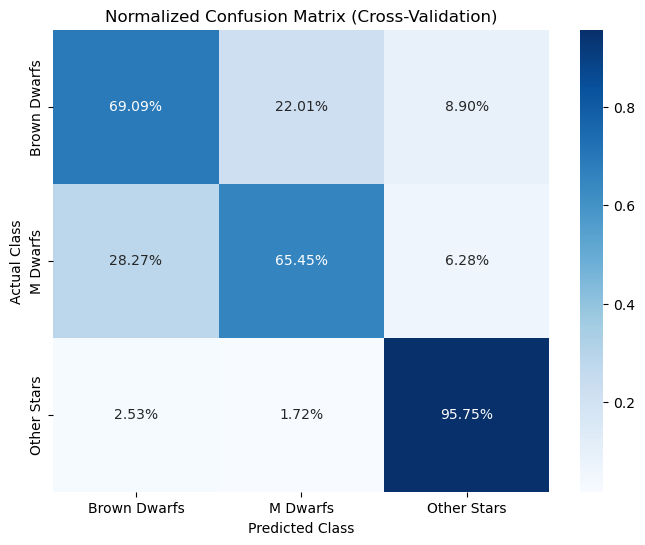

In [4]:
cm_cv = confusion_matrix(y_true_all, y_pred_all, labels=['B', 'M', 'ND'])
cm_cv_normalized = cm_cv.astype('float') / cm_cv.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cv_normalized, annot=True, fmt=".2%", cmap='Blues',
            xticklabels=['Brown Dwarfs', 'M Dwarfs', 'Other Stars'],
             yticklabels=['Brown Dwarfs', 'M Dwarfs', 'Other Stars'])
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Normalized Confusion Matrix (Cross-Validation)')
plt.show()

In [5]:
# Make predictions on the holdout set
X_HO = all_HO_dat.drop(columns=['SPEC'])
y_HO = all_HO_dat['SPEC']
y_HO_pred = knn.predict(X_HO.values) 
#NOTE: This won't work due to a bug with the 1.3.0 version.

# Apply the same scaling as used for the main dataset
X_HO_scaled = scaler.transform(X_HO)

# Step 5: Evaluate the model on the holdout set
y_HO_pred = knn.predict(X_HO_scaled)

# Print classification report for holdout set
print("Classification Report (Holdout Set):")
print(classification_report(y_HO, y_HO_pred, target_names=['B', 'M', 'ND']))

Classification Report (Holdout Set):
              precision    recall  f1-score   support

           B       0.09      0.56      0.16       273
           M       0.27      0.20      0.23      1110
          ND       0.99      0.96      0.97     32646

    accuracy                           0.93     34029
   macro avg       0.45      0.57      0.45     34029
weighted avg       0.96      0.93      0.94     34029



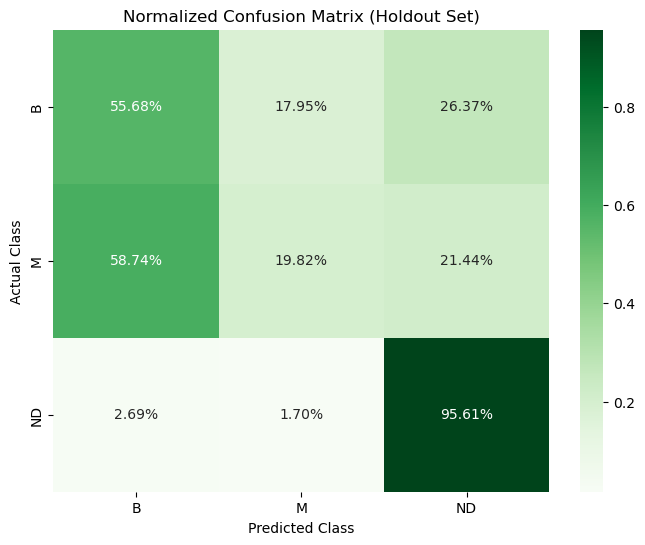

Cross-Validation Accuracy: 94.43%
Holdout Set Accuracy: 92.82%


In [139]:
# Generate and normalize confusion matrix for holdout set
cm_HO = confusion_matrix(y_HO, y_HO_pred, labels=['B', 'M', 'ND'])
cm_HO_normalized = cm_HO.astype('float') / cm_HO.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix for holdout set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_HO_normalized, annot=True, fmt=".2%", cmap='Greens',
            xticklabels=['B', 'M', 'ND'], yticklabels=['B', 'M', 'ND'])
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Normalized Confusion Matrix (Holdout Set)')
plt.show()

cv_accuracy = accuracy_score(y_true_all, y_pred_all)
holdout_accuracy = accuracy_score(y_HO, y_HO_pred)

print(f"Cross-Validation Accuracy: {cv_accuracy:.2%}")
print(f"Holdout Set Accuracy: {holdout_accuracy:.2%}")

In [205]:
#importing libraries

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso #Loading the dataset

x = all_dat
df = pd.DataFrame(x.values, columns = x.columns) #SPEC is the only string
X = df.drop("SPEC", 1)   #Feature Matrix
y = df["SPEC"]          #Target Variable
df.head()

/var/folders/6n/hk1gslsj7zg0j1jlx8vc124m0000gn/T/ipykernel_86935/2395766484.py:19: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = df.drop("SPEC", 1)   #Feature Matrix


,phot_g_mean_flux,phot_bp_mean_flux,phot_rp_mean_flux,phot_bp_rp_excess_factor,bp_rp,phot_g_mean_flux_error,phot_bp_mean_flux_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,phot_g_mean_mag_error,phot_bp_mean_mag_error,phot_rp_mean_mag_error,phot_g_mean_mag_corrected,phot_g_mean_mag_error_corrected,phot_g_mean_flux_corrected,phot_bp_rp_excess_factor_corrected,ra_epoch2000,dec_epoch2000,errHalfMaj,errHalfMin,errPosAng,astrometric_n_good_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,visibility_periods_used,dr2_rv_nb_transits,phot_g_mean_mag_error,phot_bp_mean_mag_error,phot_rp_mean_mag_error,phot_g_mean_mag_corrected,phot_g_mean_mag_error_corrected,phot_g_mean_flux_corrected,phot_bp_rp_excess_factor_corrected,ra_epoch2000_error,dec_epoch2000_error,ra_dec_epoch2000_corr,angDist,SPEC
0,204.465,38.1242,354.97,1.923,3.013125,1.23584,8.52303,19.910816,21.38554,18.372416,0.007117,0.242743,0.05468,19.885225,0.006977,209.342,0.44,100.239488,9.587415,0.01122,0.007283,115.93,195,1.2446,248.15,1.753,2.485,95,13,0,0.007117,0.242743,0.05468,19.885225,0.006977,209.342,0.44,10.5811,8.1839,-0.3309,0.457893,M
1,68757.8,55006.1,24112.1,1.151,-0.304792,61.6609,105.331,13.594062,13.487515,13.792308,0.002922,0.00348,0.00587,13.594062,0.002922,68757.8,0.004,291.539343,37.335601,0.000435,0.000388,2.71,400,1.9978,1711.71,0.231,37.25,31,28,0,0.002922,0.00348,0.00587,13.594062,0.002922,68757.8,0.004,0.3878,0.4349,0.0109,0.530093,M
2,729.109,318.622,918.046,1.696,1.739618,11.9282,17.0114,18.530386,19.080353,17.340734,0.017975,0.058035,0.053231,18.525861,0.017902,732.154,0.396,84.643564,-2.897645,0.006389,0.004887,118.1,339,27.8235,1788.3,2.801,54.08,95,21,0,0.017975,0.058035,0.053231,18.525861,0.017902,732.154,0.396,6.0876,5.2569,-0.2199,0.847162,M
3,164.563,30.8949,355.137,2.346,3.241921,5.07135,3.59646,20.146538,21.613827,18.371906,0.033573,0.126421,0.117984,20.120947,0.032796,168.488,0.829,246.653415,-24.316728,0.028482,0.014248,73.52,383,4.5693,579.51,2.604,5.181,95,12,0,0.033573,0.126421,0.117984,20.120947,0.032796,168.488,0.829,27.6092,15.873,0.3776,0.346422,M
4,1250390.0,475113.0,1120580.0,1.276,1.522256,4477.1,5577.26,10.444751,11.146549,9.624293,0.004765,0.013047,0.010732,10.444751,0.004765,1250390.0,0.003,101.967913,-25.391796,0.00023,0.000165,173.65,580,6.0452,1509.12,0.113,20.97,31,27,0,0.004765,0.013047,0.010732,10.444751,0.004765,1250390.0,0.003,0.166,0.229,-0.0737,0.466124,M


In [216]:
X = df.drop("SPEC", 1)   #Feature Matrix
y = df["SPEC"] 

#print(X.shape)
#print(y.shape)

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)
clf = DecisionTreeClassifier(max_depth=11)
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)

print(metrics.accuracy_score(ypred, ytest))

print(clf.feature_importances_) #sum is equal to 1(yay!)

print(X.columns)

#YIPPEE
#Most important features by far are bp_rp and angDist
#This can also visually be identified on the correlation matrix (Yay!)

#Forest has a feature_importances_ which is lovely, and hard to emulate for kneighbors, so I used this
#as a basis for testing other things with kneighbors

/var/folders/6n/hk1gslsj7zg0j1jlx8vc124m0000gn/T/ipykernel_86935/587608171.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = df.drop("SPEC", 1)   #Feature Matrix


0.9771188419332244
[0.00143984 0.04627469 0.00047995 0.09639325 0.30704848 0.01820476
 0.00697159 0.00140784 0.011431   0.00652195 0.00348495 0.0071998
 0.00453576 0.00165006 0.00297567 0.00696427 0.00290605 0.06542458
 0.06213517 0.00735067 0.00217576 0.00625857 0.01126954 0.01360069
 0.00807836 0.00353299 0.00578661 0.00158328 0.00395773 0.
 0.0029548  0.00671597 0.00749903 0.00478467 0.01219906 0.00093108
 0.00907396 0.00357971 0.0046812  0.01198195 0.21855473]
Index(['phot_g_mean_flux', 'phot_bp_mean_flux', 'phot_rp_mean_flux',
       'phot_bp_rp_excess_factor', 'bp_rp', 'phot_g_mean_flux_error',
       'phot_bp_mean_flux_error', 'phot_g_mean_mag', 'phot_bp_mean_mag',
       'phot_rp_mean_mag', 'phot_g_mean_mag_error', 'phot_bp_mean_mag_error',
       'phot_rp_mean_mag_error', 'phot_g_mean_mag_corrected',
       'phot_g_mean_mag_error_corrected', 'phot_g_mean_flux_corrected',
       'phot_bp_rp_excess_factor_corrected', 'ra_epoch2000', 'dec_epoch2000',
       'errHalfMaj', 'errHalf

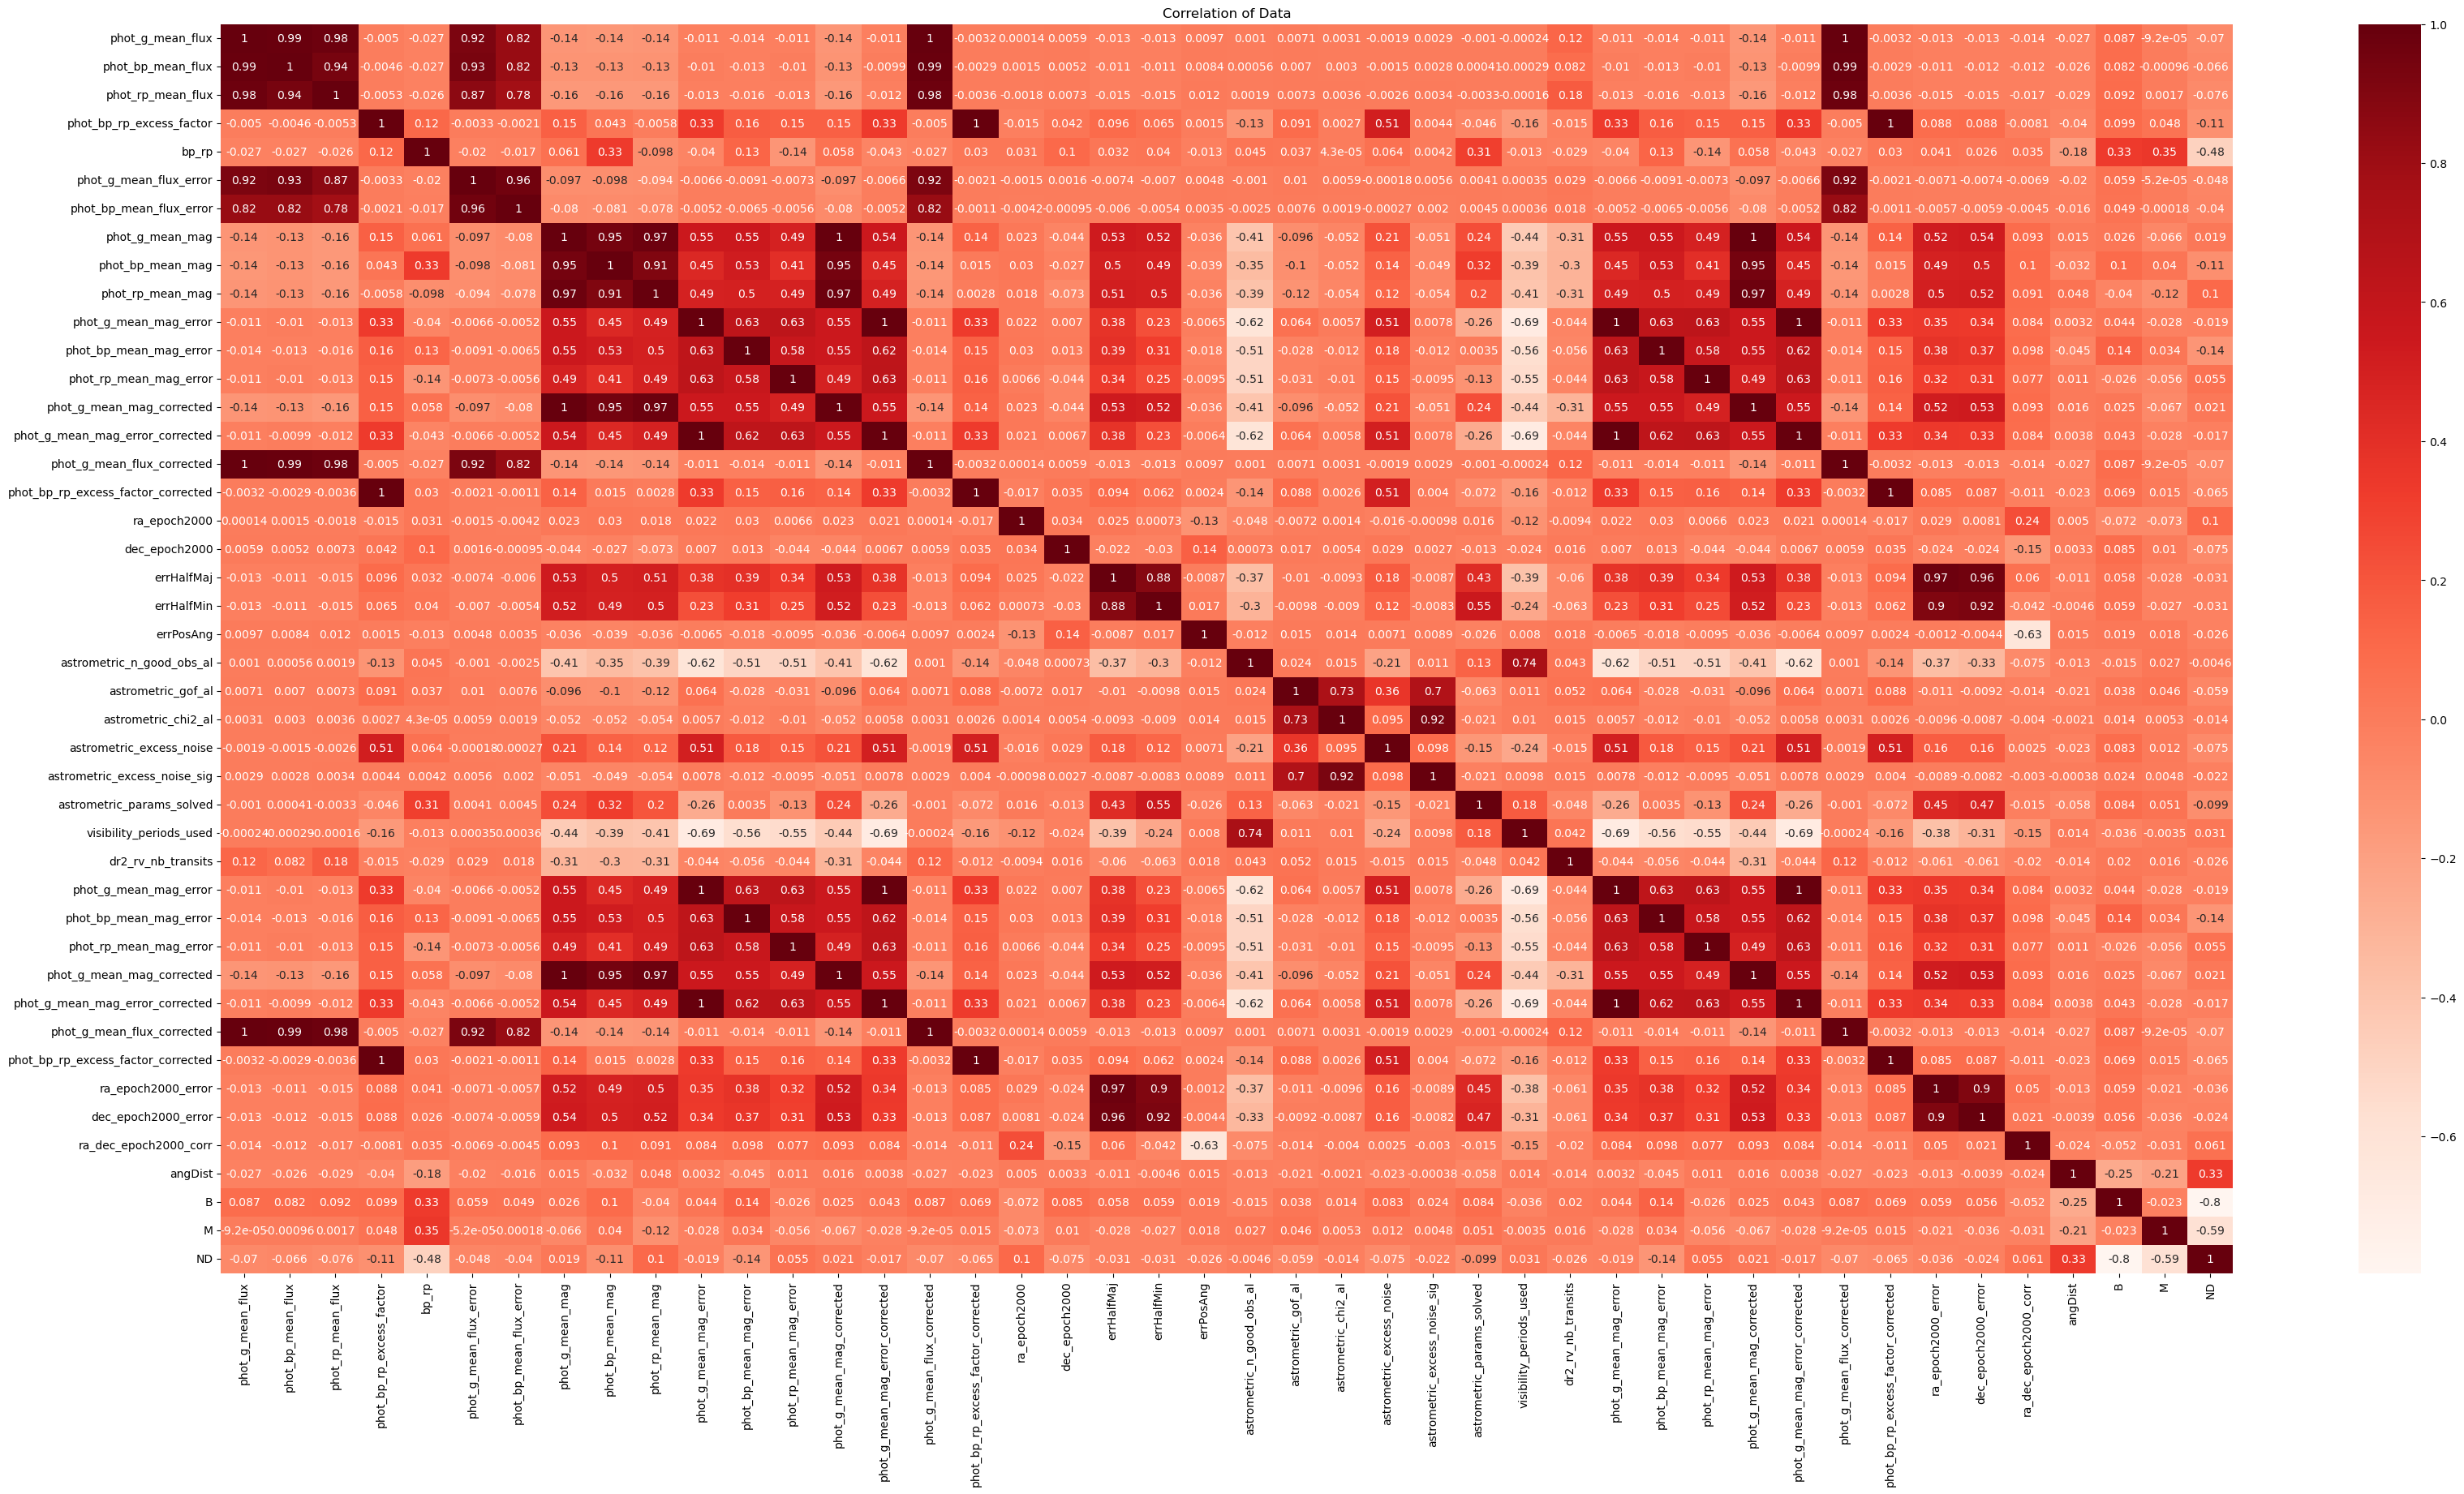

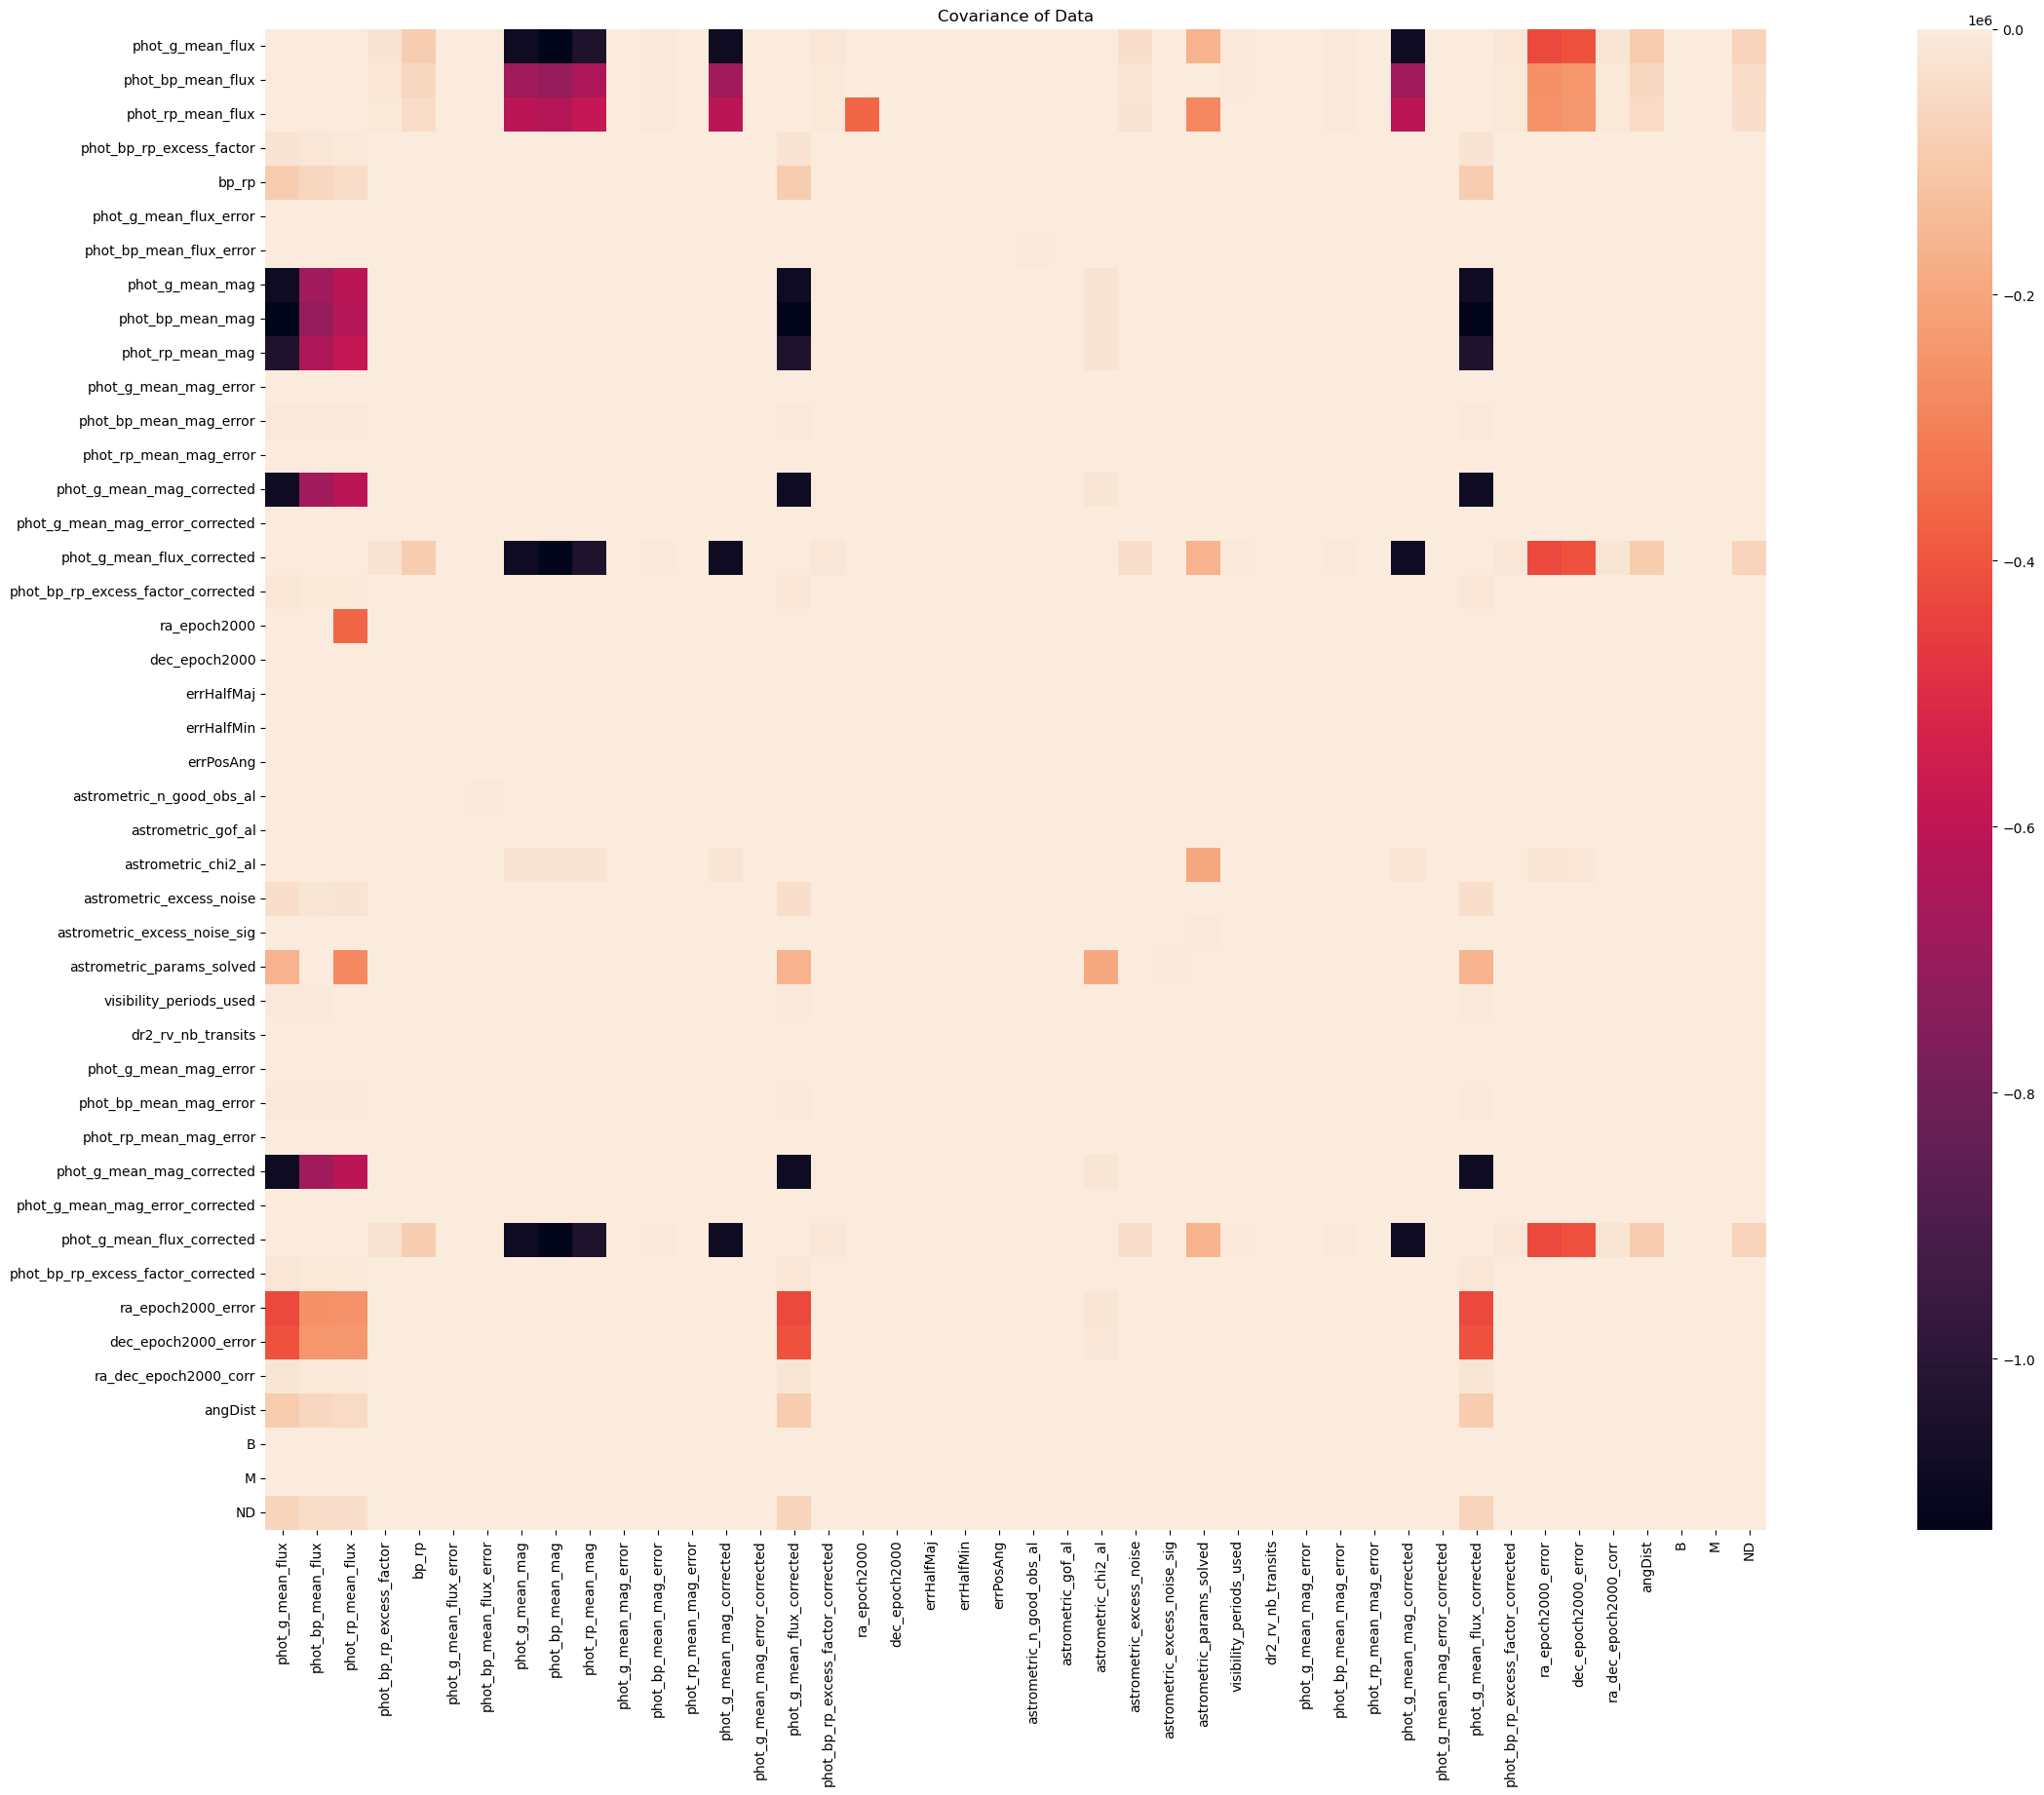

In [165]:
#If this doesn't work, go back and run the previous section again. It's about the df changing within this space
#and I'll fix it later

just_dummies = pd.get_dummies(df["SPEC"]) #SPEC dummy variables so they can all be floats
df.pop(df.columns[-1])
df = pd.concat([df, just_dummies], axis=1) 
df.head()

cor = df.corr(numeric_only=False) #Converts objects like floats to floats
#cor_norm = cor.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(40,20))
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.title("Correlation of Data")
plt.show()

plt.figure(figsize=(40,20))
data_covariance = df.cov(numeric_only=False)
sns.heatmap(data_covariance, vmax=.8, square=True)
plt.title("Covariance of Data")
plt.show()

/var/folders/6n/hk1gslsj7zg0j1jlx8vc124m0000gn/T/ipykernel_86935/3866580338.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = df.drop("M",1) #Can change up which one to look at (none of them are very impressive)
/Users/emmawallace/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent_gram(
/Users/emmawallace/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent_gram(
/Users/emmawallace/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: Convergen

/Users/emmawallace/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09227922382126508, tolerance: 0.05610215614741565
  model = cd_fast.enet_coordinate_descent_gram(
/Users/emmawallace/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.42648185245866443, tolerance: 0.05610215614741565
  model = cd_fast.enet_coordinate_descent_gram(
/Users/emmawallace/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4939037839873208, tolerance: 0.05610215614741565
  model = cd_fast.enet_coordinate_descent_gram(
/Users/emmawallace/anaconda3/lib/pytho

/Users/emmawallace/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 161.63857444763218, tolerance: 0.05610215614741565
  model = cd_fast.enet_coordinate_descent_gram(
/Users/emmawallace/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 161.16246131623112, tolerance: 0.05610215614741565
  model = cd_fast.enet_coordinate_descent_gram(
/Users/emmawallace/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 160.63849749296406, tolerance: 0.05610215614741565
  model = cd_fast.enet_coordinate_descent_gram(
/Users/emmawallace/anaconda3/lib/python3

/Users/emmawallace/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12705781274269157, tolerance: 0.05610219984670445
  model = cd_fast.enet_coordinate_descent_gram(
/Users/emmawallace/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.47790295455354226, tolerance: 0.05610219984670445
  model = cd_fast.enet_coordinate_descent_gram(
/Users/emmawallace/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9095682087717023, tolerance: 0.05610219984670445
  model = cd_fast.enet_coordinate_descent_gram(
/Users/emmawallace/anaconda3/lib/pytho

Best alpha using built-in LassoCV: 109.582306
Best score using built-in LassoCV: 0.000078
Lasso picked 6 variables and eliminated the other 37 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

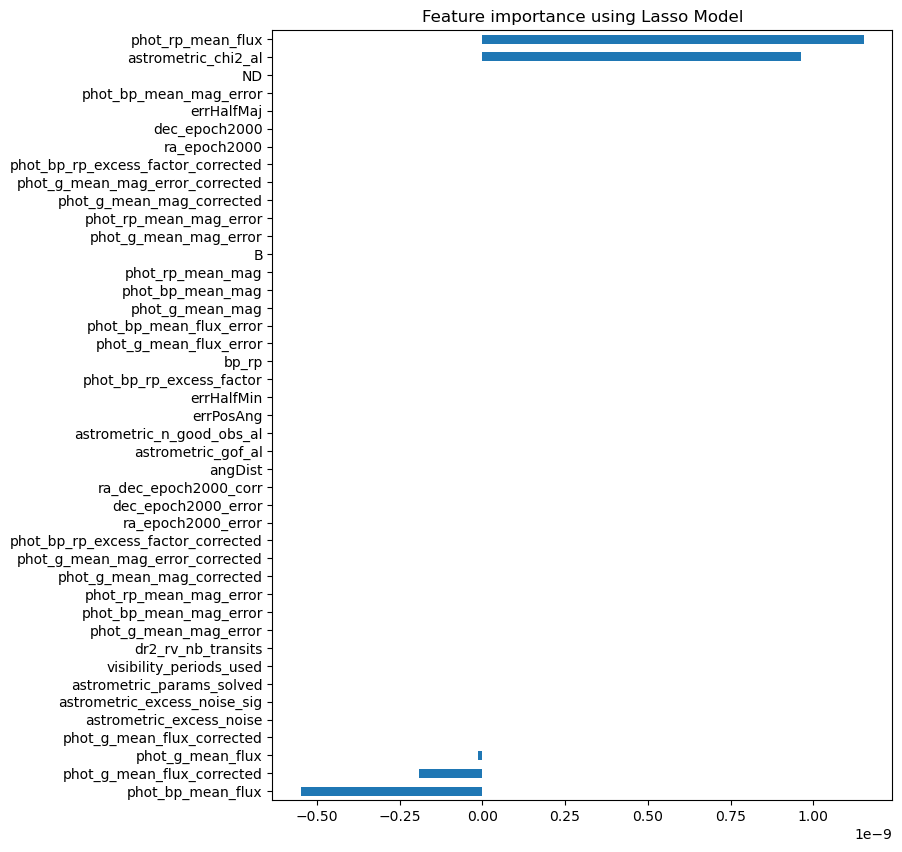

In [129]:
#This didn't really work :(

X = df.drop("M",1) #Can change up which one to look at (none of them are very impressive)
y = df["M"] 

#X = df.drop("B",1)
#y = df["B"] 

#X = df.drop("ND",1)
#y = df["ND"] 

reg = LassoCV()
reg.fit(X, y)

print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" % reg.score(X,y))

coef = pd.Series(reg.coef_, index = X.columns)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [190]:
#Permutation importance
#For some reason this just says the g_mag, so it also didn't really work :(

#print(df.head())

just_dummies = pd.get_dummies(df["SPEC"]) #SPEC dummy variables so they can all be floats
df.pop(df.columns[-1])
df = pd.concat([df, just_dummies], axis=1)

#print(df.head())

df.pop(df.columns[-2]) #M: -1, B: -1, ND: -2
df.pop(df.columns[-2]) #M: -2, B: -1, ND: -2

#print(df.head())

X_train, X_val, y_train, y_val = train_test_split(df.values, df["ND"], random_state=0)

from sklearn.linear_model import Ridge

model = Ridge(alpha=1e-2).fit(X_train, y_train)
print(model.score(X_val, y_val))

from sklearn.inspection import permutation_importance

r = permutation_importance(model, X_val, y_val, n_repeats=30, random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{df.columns[i]:<8}"f"{r.importances_mean[i]:.3f}"f" +/- {r.importances_std[i]:.3f}")
        
#M associated with phot_g_mean_flux0.923 +/- 0.000, phot_g_mean_flux_corrected0.231 +/- 0.000, 
# phot_g_mean_flux_corrected0.231 +/- 0.000. Everything else is 0.

#B associated with phot_g_mean_flux0.039 +/- 0.000, phot_g_mean_flux_corrected0.010 +/- 0.000, 
# phot_g_mean_flux_corrected0.010 +/- 0.000

# ND associated with phot_g_mean_flux0.019 +/- 0.000, phot_g_mean_flux_corrected0.005 +/- 0.000,
# phot_g_mean_flux_corrected0.005 +/- 0.000

  phot_g_mean_flux phot_bp_mean_flux phot_rp_mean_flux  \
0          204.465           38.1242            354.97   
1          68757.8           55006.1           24112.1   
2          729.109           318.622           918.046   
3          164.563           30.8949           355.137   
4        1250390.0          475113.0         1120580.0   

  phot_bp_rp_excess_factor     bp_rp phot_g_mean_flux_error  \
0                    1.923  3.013125                1.23584   
1                    1.151 -0.304792                61.6609   
2                    1.696  1.739618                11.9282   
3                    2.346  3.241921                5.07135   
4                    1.276  1.522256                 4477.1   

  phot_bp_mean_flux_error phot_g_mean_mag phot_bp_mean_mag phot_rp_mean_mag  \
0                 8.52303       19.910816         21.38554        18.372416   
1                 105.331       13.594062        13.487515        13.792308   
2                 17.0114       18.

0.9999999998700082
ND      1.999 +/- 0.021
phot_g_mean_flux0.019 +/- 0.000
phot_g_mean_flux_corrected0.005 +/- 0.000
phot_g_mean_flux_corrected0.005 +/- 0.000
phot_bp_rp_excess_factor0.000 +/- 0.000
phot_bp_rp_excess_factor_corrected0.000 +/- 0.000
phot_bp_rp_excess_factor_corrected0.000 +/- 0.000
phot_g_mean_mag0.000 +/- 0.000
phot_g_mean_mag_corrected0.000 +/- 0.000
phot_g_mean_mag_corrected0.000 +/- 0.000
phot_bp_mean_flux0.000 +/- 0.000
phot_bp_mean_mag0.000 +/- 0.000
phot_rp_mean_flux0.000 +/- 0.000
bp_rp   0.000 +/- 0.000
phot_rp_mean_mag0.000 +/- 0.000
phot_g_mean_flux_error0.000 +/- 0.000
angDist 0.000 +/- 0.000
phot_bp_mean_flux_error0.000 +/- 0.000
astrometric_params_solved0.000 +/- 0.000
ra_epoch20000.000 +/- 0.000
ra_dec_epoch2000_corr0.000 +/- 0.000
errHalfMin0.000 +/- 0.000
ra_epoch2000_error0.000 +/- 0.000
phot_rp_mean_mag_error0.000 +/- 0.000
phot_rp_mean_mag_error0.000 +/- 0.000
dec_epoch20000.000 +/- 0.000
astrometric_n_good_obs_al0.000 +/- 0.000
phot_bp_mean_mag_erro

In [162]:
#Should show the correlation between SPEC and all other classes
#Everything returns NaN :(

#just_dummies = pd.get_dummies(df["SPEC"])
#df.pop(df.columns[-1])
#corrwith = df.corrwith(just_dummies, axis=0, numeric_only=False)

#print(corrwith)